<a href="https://colab.research.google.com/github/Kanyinsola-O/CE888/blob/main/Lab7/Lab7P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import layers, models
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.layers import Dense
from keras.layers import Embedding, SimpleRNN
import numpy
import math
import matplotlib.pyplot as plt
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping

In [2]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [3]:
train_size = int(len(dataset) * 0.30) #change size of train and test size it showed an improvement in the model, anything below 30 train size would diminish the models abilities
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [4]:
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) #Added callback to avoid overfitting
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(5, input_shape=(1, look_back))) #Five neurones performed better then 4
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
mod = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, callbacks=callback, validation_data=(testX, testY)) #added validation to plot loss curve and address over or under fitting

Epoch 1/100
41/41 - 2s - loss: 0.0086 - val_loss: 0.2157
Epoch 2/100
41/41 - 0s - loss: 0.0036 - val_loss: 0.1791
Epoch 3/100
41/41 - 0s - loss: 0.0029 - val_loss: 0.1657
Epoch 4/100
41/41 - 0s - loss: 0.0029 - val_loss: 0.1583
Epoch 5/100
41/41 - 0s - loss: 0.0028 - val_loss: 0.1529
Epoch 6/100
41/41 - 0s - loss: 0.0027 - val_loss: 0.1480
Epoch 7/100
41/41 - 0s - loss: 0.0027 - val_loss: 0.1446
Epoch 8/100
41/41 - 0s - loss: 0.0026 - val_loss: 0.1397
Epoch 9/100
41/41 - 0s - loss: 0.0025 - val_loss: 0.1287
Epoch 10/100
41/41 - 0s - loss: 0.0025 - val_loss: 0.1294
Epoch 11/100
41/41 - 0s - loss: 0.0024 - val_loss: 0.1227
Epoch 12/100
41/41 - 0s - loss: 0.0023 - val_loss: 0.1189
Epoch 13/100
41/41 - 0s - loss: 0.0023 - val_loss: 0.1119
Epoch 14/100
41/41 - 0s - loss: 0.0022 - val_loss: 0.1064
Epoch 15/100
41/41 - 0s - loss: 0.0021 - val_loss: 0.1029
Epoch 16/100
41/41 - 0s - loss: 0.0021 - val_loss: 0.0995
Epoch 17/100
41/41 - 0s - loss: 0.0020 - val_loss: 0.0923
Epoch 18/100
41/41 - 0s

In [5]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 14.82 RMSE
Test Score: 38.91 RMSE


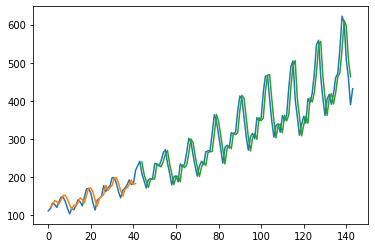

In [6]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

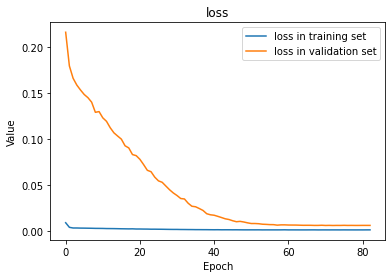

In [7]:
def plot_curve(metric, save=False, saveas='test'):
    '''Plots the learning curve for the model
    based on history, metric takes any acceptable metric
    by the model e.g. Loss, if save is set to true
    saves a copy of the graph under the name specified
    in saveas by default is test'''
    plt.plot(mod.history[metric], label=f'{metric} in training set')
    plt.plot(mod.history[f'val_{metric}'],
             label=f'{metric} in validation set')
    plt.title(metric)
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend()
    if save:
        plt.savefig(f'{saveas}')
    plt.show()
plot_curve('loss')

In [8]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.70) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 40 #changed lookback to 40 to see effec it has
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) #Added callback to avoid overfitting
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) 
model.add(Dense(1)) #increase numbered of neurons in dense layer
model.compile(loss='mean_squared_error', optimizer='adam')
mod = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, callbacks=callback, validation_data=(testX, testY)) #added validation to plot loss curve and address over or under fitting

Epoch 1/100
59/59 - 2s - loss: 0.0296 - val_loss: 0.0391
Epoch 2/100
59/59 - 0s - loss: 0.0053 - val_loss: 0.0257
Epoch 3/100
59/59 - 0s - loss: 0.0049 - val_loss: 0.0134
Epoch 4/100
59/59 - 0s - loss: 0.0047 - val_loss: 0.0134
Epoch 5/100
59/59 - 0s - loss: 0.0041 - val_loss: 0.0109
Epoch 6/100
59/59 - 0s - loss: 0.0040 - val_loss: 0.0086
Epoch 7/100
59/59 - 0s - loss: 0.0036 - val_loss: 0.0048
Epoch 8/100
59/59 - 0s - loss: 0.0032 - val_loss: 0.0039
Epoch 9/100
59/59 - 0s - loss: 0.0031 - val_loss: 0.0042
Epoch 10/100
59/59 - 0s - loss: 0.0027 - val_loss: 0.0023
Epoch 11/100
59/59 - 0s - loss: 0.0025 - val_loss: 0.0023
Epoch 12/100
59/59 - 0s - loss: 0.0024 - val_loss: 0.0027
Epoch 13/100
59/59 - 0s - loss: 0.0021 - val_loss: 0.0025
Epoch 14/100
59/59 - 0s - loss: 0.0019 - val_loss: 0.0037
Epoch 15/100
59/59 - 0s - loss: 0.0018 - val_loss: 0.0022
Epoch 16/100
59/59 - 0s - loss: 0.0017 - val_loss: 0.0085
Epoch 17/100
59/59 - 0s - loss: 0.0017 - val_loss: 0.0057
Epoch 18/100
59/59 - 0s

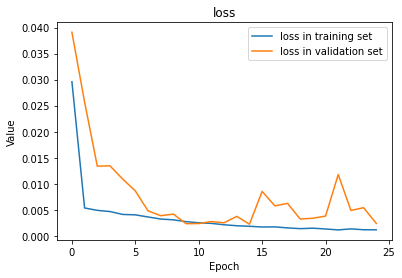

In [9]:
plot_curve('loss')


In [10]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 20.89 RMSE
Test Score: 24.39 RMSE


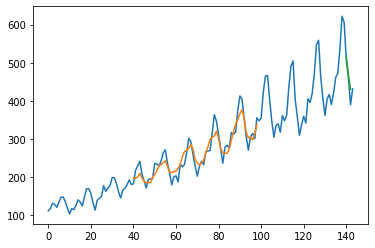

In [11]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()